In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew 
from scipy.stats import norm
from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from datetime import datetime

In [2]:
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

In [3]:
# Load the data
data = pd.read_csv('train.csv')

In [4]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
data.shape

(1460, 81)

In [6]:
# Drop the ID column as its not required for prediction

train_id = data['Id']
data  =  data.drop('Id', axis = 'columns')

In [7]:
data.shape

(1460, 80)

###### Missing Data

In [8]:
missing_df = data.isnull().mean() * 100
missing_df = missing_df.drop(missing_df[missing_df == 0].index).sort_values(ascending = False)
missing_df = pd.DataFrame(missing_df, columns = {'Missing Ratio'})
missing_df

,Missing Ratio
PoolQC,99.521
MiscFeature,96.301
Alley,93.767
Fence,80.753
FireplaceQu,47.260
LotFrontage,17.740
GarageYrBlt,5.548
GarageType,5.548
GarageFinish,5.548
GarageQual,5.548


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, 'PoolQC'),
  Text(1, 0, 'MiscFeature'),
  Text(2, 0, 'Alley'),
  Text(3, 0, 'Fence'),
  Text(4, 0, 'FireplaceQu'),
  Text(5, 0, 'LotFrontage'),
  Text(6, 0, 'GarageYrBlt'),
  Text(7, 0, 'GarageType'),
  Text(8, 0, 'GarageFinish'),
  Text(9, 0, 'GarageQual'),
  Text(10, 0, 'GarageCond'),
  Text(11, 0, 'BsmtFinType2'),
  Text(12, 0, 'BsmtExposure'),
  Text(13, 0, 'BsmtFinType1'),
  Text(14, 0, 'BsmtCond'),
  Text(15, 0, 'BsmtQual'),
  Text(16, 0, 'MasVnrArea'),
  Text(17, 0, 'MasVnrType'),
  Text(18, 0, 'Electrical')])

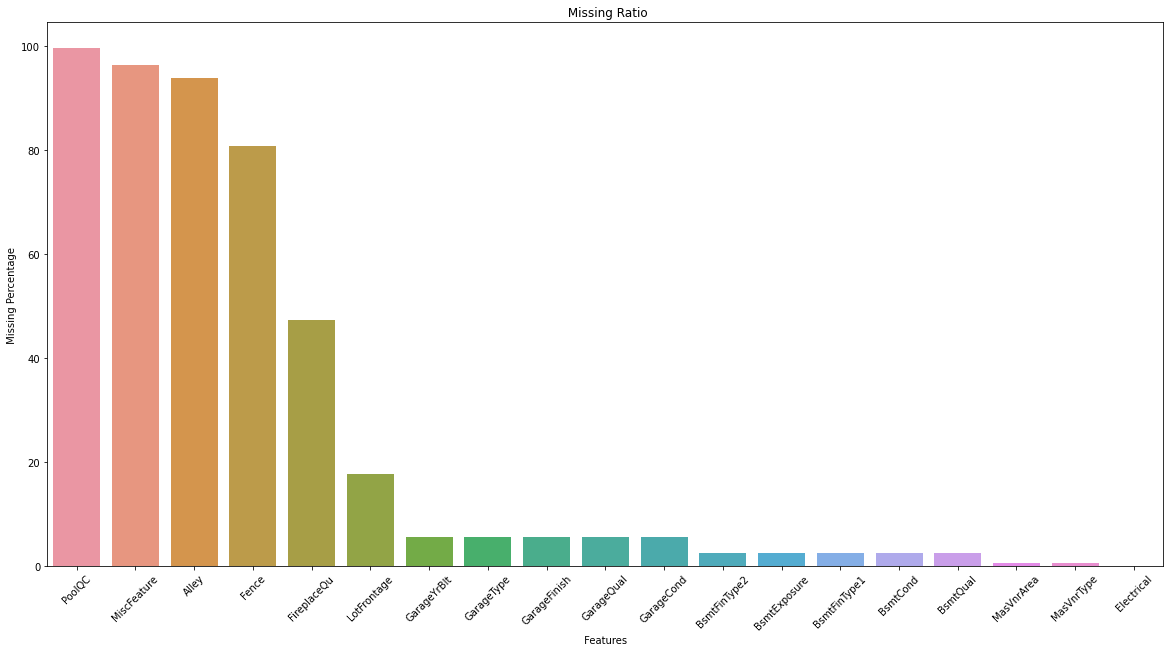

In [9]:
plt.rcParams['figure.figsize'] = (20, 10)
sns.barplot(x = missing_df.index, y = missing_df['Missing Ratio'])
plt.title(' Missing Ratio')
plt.xlabel(' Features ')
plt.ylabel(' Missing Percentage ')
plt.xticks(rotation = '45')


#### We start handling the missing values by going through each features

1. PoolQC - Pool Quality in which NA means the house doesnt contain pool which makes sense of having so many missing (99.5%)

In [10]:
data['PoolQC'] = data['PoolQC'].fillna("None")

2. MiscFeature - Containts details of Garage, Tennis Court, Shed and other details, so we can set to None as the home doesn't contain these facilities

In [11]:
data['MiscFeature'].unique()

array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [12]:
data['MiscFeature'] = data['MiscFeature'].fillna('None')

3. Alley - Type of alley access to home (Paved, Gavel or no access)

In [13]:
data['Alley'].unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

In [14]:
data['Alley'] = data['Alley'].fillna('None')

4. Fence - Quality of fence Good, Min Privacy, Good wood or No Fence

In [15]:
data['Fence'].unique()

array([nan, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

In [16]:
data['Fence'] = data['Fence'].fillna('None')

5. FireplaceQu - Quality of Fire Place (None for no fire place)

In [17]:
data['FireplaceQu'].unique()

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [18]:
data['FireplaceQu'] = data['FireplaceQu'].fillna('None')

6. LotFrontage: Linear feet of street connected to property - since the distance for house property might be mostly similiar to neigborhood we can use Median for the missing ones

In [19]:
data['LotFrontage'].isnull().sum()

259

In [20]:
data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

7. GarageYrBlt: Year garage was built

In [21]:
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(0)

8. GarageType - Type of Garage, NA for no garage

In [22]:
data['GarageType'].unique()

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', nan, 'Basment', '2Types'],
      dtype=object)

In [23]:
data['GarageType'] = data['GarageType'].fillna('None')

9. GarageFinish - Interior finish of the garage; NA for no garage

In [24]:
data['GarageFinish'] = data['GarageFinish'].fillna('None')

10. GarageQual - Garage quality; NA for no garage

In [25]:
data['GarageQual'] = data['GarageQual'].fillna('None')

11. GarageCond: Garage condition; NA for no garage

In [26]:
data['GarageCond'] = data['GarageCond'].fillna('None')

12. BsmtFinType2: Rating of basement finished area (if multiple types); NA no basement

In [27]:
data['BsmtFinType2'] = data['BsmtFinType2'].fillna('None')

13. BsmtExposure: Refers to walkout or garden level walls; NA for no basement

In [28]:
data['BsmtExposure'] = data['BsmtExposure'].fillna('None')

14. BsmtFinType1: Rating of basement finished area; NA for no basement

In [29]:
data['BsmtFinType1'] = data['BsmtFinType1'].fillna('None')

15. BsmtCond: Evaluates the general condition of the basement; NA for no basement

In [30]:
data['BsmtCond'] = data['BsmtCond'].fillna('None')

16. BsmtQual: Evaluates the height of the basement; NA for no basement

In [31]:
data['BsmtQual'] = data['BsmtQual'].fillna('None')

17. MasVnrArea: Masonry veneer area in square feet; NA means no Masonry Veneer for the house so we fill with 0

In [32]:
data['MasVnrArea'] = data['MasVnrArea'].fillna(0)

18. MasVnrType: Masonry veneer type; NA for none

In [33]:
data['MasVnrType'].unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

In [34]:
data['MasVnrType'] = data['MasVnrType'].fillna('None')

19. Electrical: Electrical system; Since only one missing value we replace with mode (SBrkr)

In [35]:
data['Electrical'].isnull().sum()

1

In [36]:
data['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [37]:
data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])

In [38]:
data['Utilities'].value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

Since all the values point to All Pub and only one to NoSeWa, it wont help the model so we can safely drop this column

In [39]:
data.drop(['Utilities'], axis = 'columns', inplace = True)

In [40]:
data.isnull().sum().sum()

0

No Missing value present

Outliers 

In [41]:
# Quantitative features
quantitative = [f for f in data.columns if data.dtypes[f] != 'object']
quantitative.remove('SalePrice') # Remove the Target Feature
qualitative = [f for f in data.columns if data.dtypes[f] == 'object']

In [42]:
print('Quantitative count: ', len(quantitative))
print('Qualitative count: ', len(qualitative))


Quantitative count:  36
Qualitative count:  42


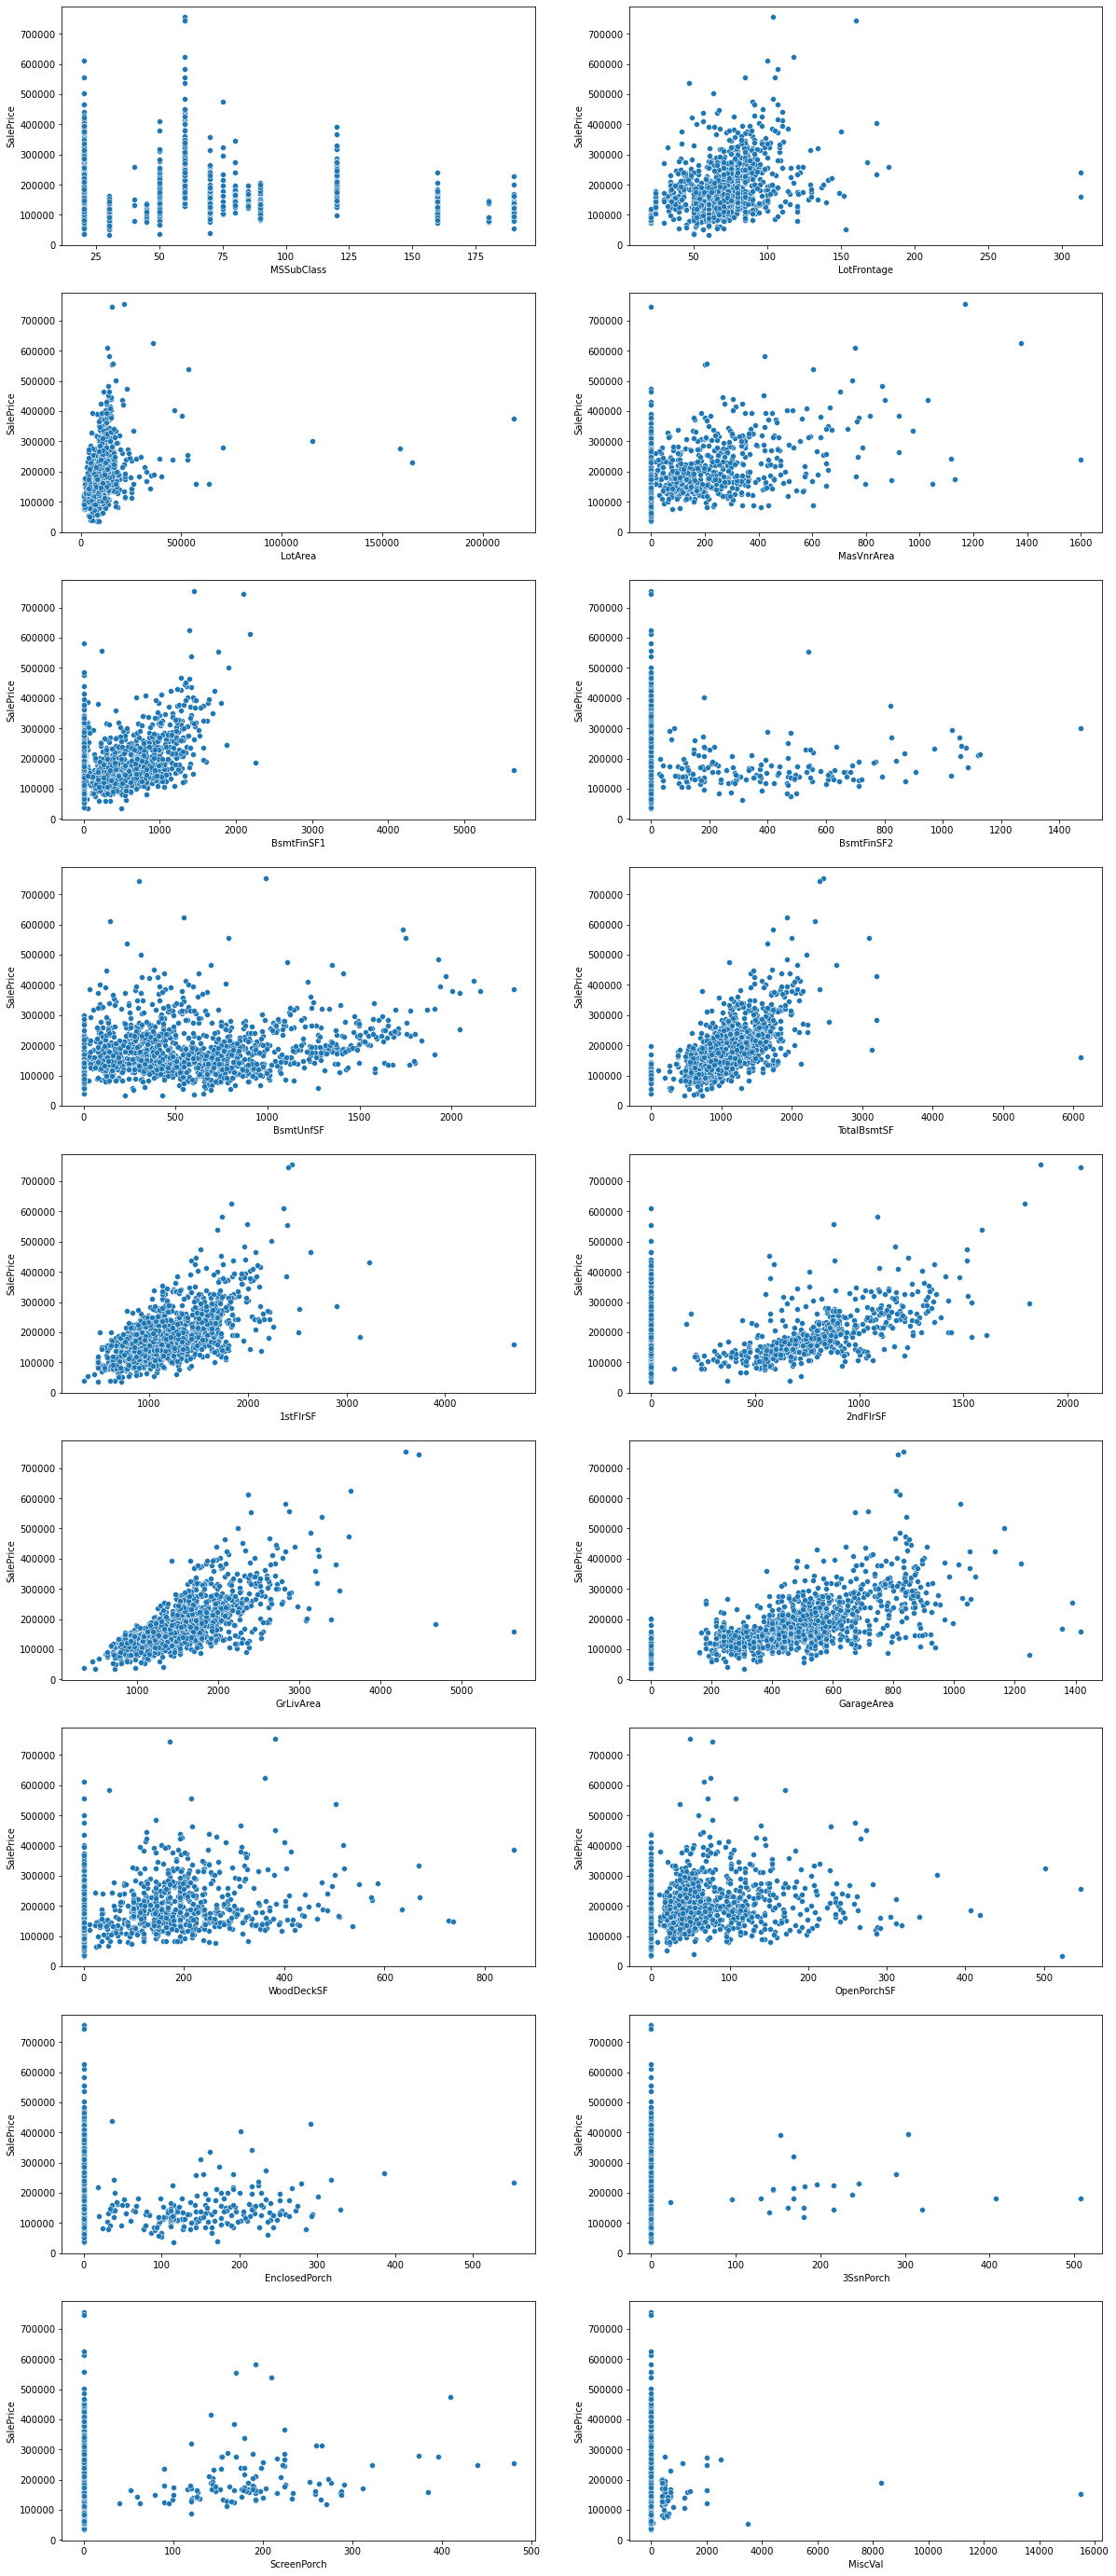

In [43]:
plt.rcParams['figure.figsize'] = (20, 50)
list_features = ['MSSubClass', 'LotFrontage','LotArea','MasVnrArea',
                 'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',
                 'GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
                 'ScreenPorch','MiscVal']

i = 0
fig, axs = plt.subplots(9, 2)
for row in range(0,9):
    for col in range(0,2):
        sns.scatterplot(x = list_features[i], y = 'SalePrice', data = data, ax = axs[row][col])
        i = i + 1

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

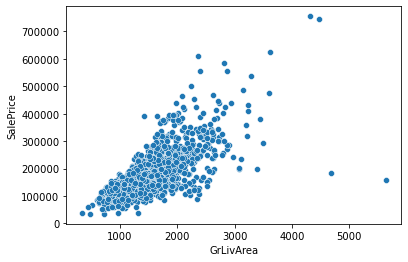

In [44]:
plt.rcParams['figure.figsize'] = (6, 4)
sns.scatterplot(x = 'GrLivArea', y = 'SalePrice', data = data)

In [45]:
# Deleting the outlier

data = data.drop(data[(data['GrLivArea']>4000) & (data['SalePrice']<300000)].index)

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

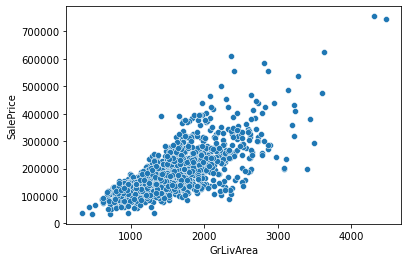

In [46]:
plt.rcParams['figure.figsize'] = (6, 4)
sns.scatterplot(x = 'GrLivArea', y = 'SalePrice', data = data)

In [47]:
skewed_features = data[quantitative].apply(lambda x: skew(x)).sort_values(ascending = False)
skewed_features[skewed_features > 0.75]

MiscVal         24.435
PoolArea        15.933
LotArea         12.561
3SsnPorch       10.287
LowQualFinSF     8.996
KitchenAbvGr     4.480
BsmtFinSF2       4.248
ScreenPorch      4.115
BsmtHalfBath     4.096
EnclosedPorch    3.084
MasVnrArea       2.694
OpenPorchSF      2.337
LotFrontage      1.546
WoodDeckSF       1.544
MSSubClass       1.406
GrLivArea        1.010
BsmtUnfSF        0.920
1stFlrSF         0.887
2ndFlrSF         0.812
BsmtFinSF1       0.764
dtype: float64

In [48]:
skewed_features = skewed_features[skewed_features > 0.75]
skewed_features.index

Index(['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch', 'LowQualFinSF',
       'KitchenAbvGr', 'BsmtFinSF2', 'ScreenPorch', 'BsmtHalfBath',
       'EnclosedPorch', 'MasVnrArea', 'OpenPorchSF', 'LotFrontage',
       'WoodDeckSF', 'MSSubClass', 'GrLivArea', 'BsmtUnfSF', '1stFlrSF',
       '2ndFlrSF', 'BsmtFinSF1'],
      dtype='object')

Checking the correlation of skewed data

<AxesSubplot:>

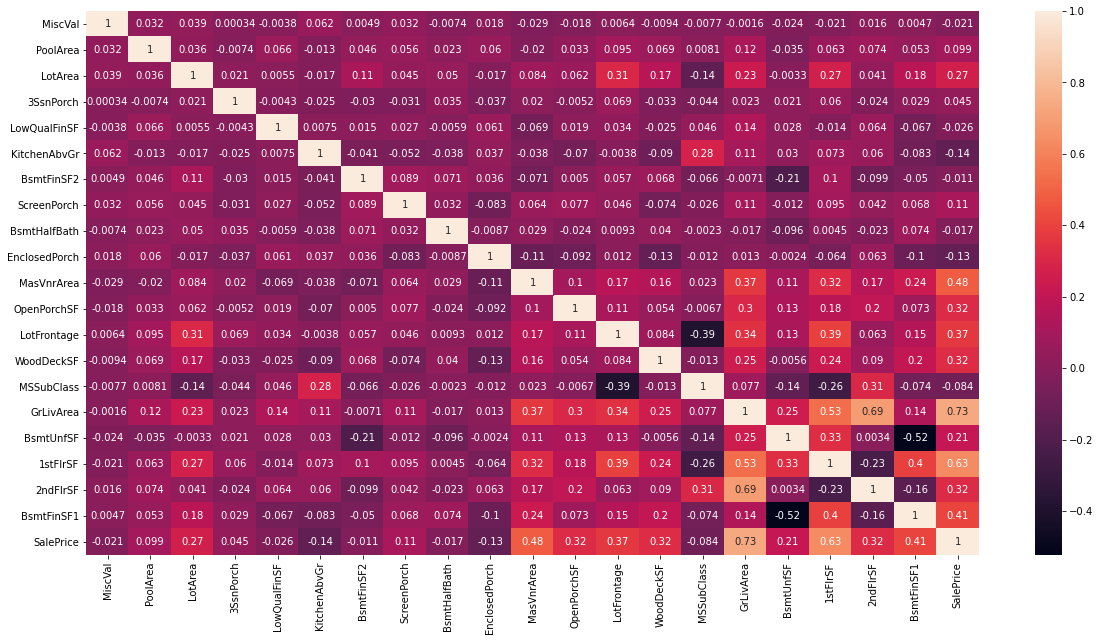

In [49]:
plt.rcParams['figure.figsize'] = (20, 10)
sns.heatmap(data[['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch', 'LowQualFinSF',
       'KitchenAbvGr', 'BsmtFinSF2', 'ScreenPorch', 'BsmtHalfBath',
       'EnclosedPorch', 'MasVnrArea', 'OpenPorchSF', 'LotFrontage',
       'WoodDeckSF', 'MSSubClass', 'GrLivArea', 'BsmtUnfSF', '1stFlrSF',
       '2ndFlrSF', 'BsmtFinSF1','SalePrice']].corr(), annot = True)

In [50]:
# We are dropping these features 'GrLivArea','1stFlrSF','MasVnrArea','BsmtFinSF1' from transformation as
# they are haivng high correlation with the target feature (Sales Price)

skewed_features = skewed_features.drop(['GrLivArea','1stFlrSF','MasVnrArea','BsmtFinSF1'])
for feature in skewed_features.index:
#     data[feature] = boxcox1p(data[feature], 0.15)
    data[feature] = np.sqrt(data[feature])
#     data[feature] = np.log1p(data[feature])
#     data[feature] = boxcox1p(data[feature], boxcox_normmax(data[feature] + 1))
            
    

In [51]:
data[quantitative].apply(lambda x: skew(x)).sort_values(ascending = False)

PoolArea        15.596
MiscVal          9.543
3SsnPorch        8.263
LowQualFinSF     8.051
LotArea          4.191
BsmtHalfBath     3.887
ScreenPorch      3.348
KitchenAbvGr     3.100
BsmtFinSF2       3.031
MasVnrArea       2.694
EnclosedPorch    2.343
GrLivArea        1.010
1stFlrSF         0.887
BsmtFinSF1       0.764
MSSubClass       0.762
OverallCond      0.690
HalfBath         0.679
TotRmsAbvGrd     0.660
Fireplaces       0.631
BsmtFullBath     0.590
OpenPorchSF      0.589
TotalBsmtSF      0.511
WoodDeckSF       0.490
2ndFlrSF         0.424
MoSold           0.215
BedroomAbvGr     0.212
OverallQual      0.201
GarageArea       0.132
YrSold           0.095
LotFrontage      0.032
FullBath         0.031
BsmtUnfSF       -0.245
GarageCars      -0.342
YearRemodAdd    -0.501
YearBuilt       -0.612
GarageYrBlt     -3.862
dtype: float64

In [52]:
#Year and month sold are transformed into categorical features.
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)


In [53]:

data['YrBltAndRemod']=data['YearBuilt']+data['YearRemodAdd']

data['TotalSF']=data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

data['Total_sqr_footage'] = (data['BsmtFinSF1'] + data['BsmtFinSF2'] +
                                 data['1stFlrSF'] + data['2ndFlrSF'])

data['Total_Bathrooms'] = (data['FullBath'] + (0.5 * data['HalfBath']) +
                               data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath']))

data['Total_porch_sf'] = (data['OpenPorchSF'] + data['3SsnPorch'] +
                              data['EnclosedPorch'] + data['ScreenPorch'] +
                              data['WoodDeckSF'])

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

In [54]:
# Ordinal Encoding

order_map = {'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5, 'None':6}
garage_finish_order = {'Fin': 1, 'RFn': 2, 'Unf': 3, 'None': 4}
lot_shape_order = { 'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3' : 4, 'None' : 5}
fence_order = {'GdPrv' : 1,'MnPrv' : 2,'GdWo':3, 'MnWw':4, 'None':5 }
BsmtExposure_order = { 'Gd' : 1, 'Av' : 2, 'Mn' : 3, 'No' : 4, 'None' : 5}
BsmtFinType_order = {'GLQ' : 1, 'ALQ' : 2, 'BLQ' : 3, 'Rec' : 4, 'LwQ': 5, 'Unf' : 6, 'None' : 7}
                                

In [55]:
data['ExterQual'] = data['ExterQual'].map(order_map)
data['BsmtQual'] = data['BsmtQual'].map(order_map)
data['BsmtCond'] = data['BsmtCond'].map(order_map)
data['HeatingQC'] = data['HeatingQC'].map(order_map)
data['FireplaceQu'] = data['FireplaceQu'].map(order_map)
data['KitchenQual'] = data['KitchenQual'].map(order_map)
data['GarageQual'] = data['GarageQual'].map(order_map)
data['GarageCond'] = data['GarageCond'].map(order_map)
data['PoolQC'] = data['PoolQC'].map(order_map)

data['GarageFinish'] = data['GarageFinish'].map(order_map)
data['LotShape'] = data['LotShape'].map(lot_shape_order)
data['Fence'] = data['Fence'].map(fence_order)
data['BsmtExposure'] = data['BsmtExposure'].map(BsmtExposure_order)
data['BsmtFinType1'] = data['BsmtFinType1'].map(BsmtFinType_order)
data['BsmtFinType2'] = data['BsmtFinType2'].map(BsmtFinType_order)

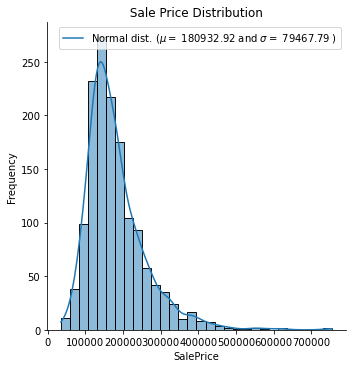

In [56]:
(mu, sigma) = norm.fit(data['SalePrice'])
sns.displot(data['SalePrice'], kde = True, bins = 30)
plt.ylabel('Frequency')
plt.title(' Sale Price Distribution ')
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')

((array([-3.3047554 , -3.04752042, -2.90446807, ...,  2.90446807,
          3.04752042,  3.3047554 ]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000], dtype=int64)),
 (74213.25959976624, 180932.91906721535, 0.9320154492892367))

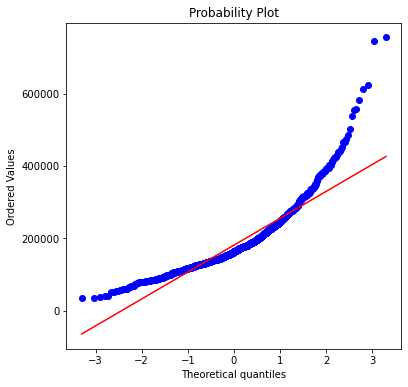

In [57]:
plt.rcParams['figure.figsize'] = (6,6)
stats.probplot(data['SalePrice'],plot = plt)

In [58]:
# Log Transformation for Sales Price
data['SalePrice'] = np.log1p(data['SalePrice'])

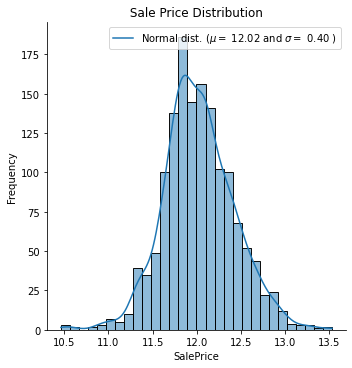

In [59]:
(mu, sigma) = norm.fit(data['SalePrice'])
sns.displot(data['SalePrice'], kde = True, bins = 30)
plt.ylabel('Frequency')
plt.title(' Sale Price Distribution ')
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')

((array([-3.3047554 , -3.04752042, -2.90446807, ...,  2.90446807,
          3.04752042,  3.3047554 ]),
  array([10.46027076, 10.47197813, 10.54273278, ..., 13.34550853,
         13.52114084, 13.53447435])),
 (0.3985294832980731, 12.024015155682548, 0.9953918721417083))

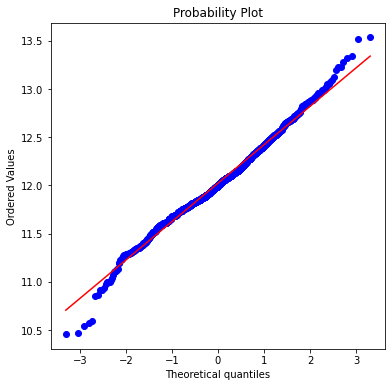

In [60]:
plt.rcParams['figure.figsize'] = (6,6)
stats.probplot(data['SalePrice'],plot = plt)

In [61]:
final_data = pd.get_dummies(data)
print(final_data.shape)
print(data.shape)

(1458, 258)
(1458, 84)


In [62]:
final_data.head()

,MSSubClass,LotFrontage,LotArea,LotShape,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,7.746,8.062,91.924,1,7,5,2003,2003,196.000,2,...,0,0,0,1,0,0,0,0,1,0
1,4.472,8.944,97.980,1,6,8,1976,1976,0.000,3,...,0,0,0,1,0,0,0,0,1,0
2,7.746,8.246,106.066,2,7,5,2001,2002,162.000,2,...,0,0,0,1,0,0,0,0,1,0
3,8.367,7.746,97.724,2,7,5,1915,1970,0.000,3,...,0,0,0,1,1,0,0,0,0,0
4,7.746,9.165,119.415,2,8,5,2000,2000,350.000,2,...,0,0,0,1,0,0,0,0,1,0


In [63]:
X = final_data.drop(['SalePrice'], axis = 'columns')
y = final_data['SalePrice']

In [64]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [65]:

xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)


In [66]:
xgboost.fit(X_train, y_train)
y_pred = xgboost.predict(X_test)
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('R2 Score: {:.4f}'.format(score))
print('RMSE: {:.4f}'.format(rmse))

# R2 Score: 0.9226
# RMSE: 0.1103

R2 Score: 0.9226
RMSE: 0.1103


In [67]:
# K Fold Cross validation

scores = cross_val_score(xgboost, X, y, cv = 10)
scores

array([0.91072829, 0.94492311, 0.94672401, 0.90954275, 0.90664394,
       0.92589037, 0.9217844 , 0.93379517, 0.94331671, 0.89711051])

In [68]:
print('R2 Score: {:.4f}'.format(scores.mean()))

R2 Score: 0.9240
